# Definitions

## Import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import yt

import athena_read as ar

# import seaborn as sns

plt.style.use('../plot_scripts/plot_style.mplstyle')

import para_scan as ps
import v_turb as vt
# import tgrow as tg

/afs/mpa/data/hitesh/envs/athenaenv/lib/python3.9/_collections_abc.py:769: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


## Class hst_data definitions

In [2]:
class hst_data:

    def __init__(self, fn, ncells, MHD_flag=False, cool_flag=False):

        """Read hst and return structured numpy dict.
        Keyword Arguments:
        fn -- 
        """

        hdr = []
        with open(fn, 'r') as fp:
            while True:
                l = fp.readline()
                if l[0] != '#':
                    raise Exception("No header in %s found!" %(fn))
                if '[1]' in l:
                    hdr = [i.split("=")[1].strip() for i in l[1:].split("[") if ']' in i]
                    break

        r = np.loadtxt(fn, dtype={'names' : hdr, 'formats' : len(hdr) * (float,)})

        self.dict = r

        self.time  = self.dict['time']
        self.dt    = self.dict['dt']

        self.mass_tot  = self.dict['mass']

        self.mom1  = self.dict['1-mom']
        self.mom2  = self.dict['2-mom']
        self.mom3  = self.dict['3-mom']

        self.KE1   = self.dict['1-KE']
        self.KE2   = self.dict['2-KE']
        self.KE3   = self.dict['3-KE']
        self.E_tot = self.dict['tot-E']

        if cool_flag:
            self.cold_gas = self.dict['cold_gas']
            self.tcool_avg = self.dict['tcool_sum']/ncells
            self.cold_gas_fraction = self.cold_gas/self.mass_tot

        self.rho_avg    = self.dict['rho_sum']/ncells
        self.rho_sq_avg = self.dict['rho_sq_sum']/ncells

        self.cs_avg    = self.dict['c_s_sum']/ncells

        if MHD_flag:

            self.Pth_avg = self.dict['Pth_sum']/ncells
            self.PB_avg  = self.dict['PB_sum']/ncells
            self.Bx_avg  = self.dict['Bx_sum']/ncells
            self.By_avg  = self.dict['By_sum']/ncells
            self.Bz_avg  = self.dict['Bz_sum']/ncells

            self.B_abs_avg = np.sqrt(self.PB_avg*2)
            self.dB = np.roll(self.B_abs_avg,-1) - self.B_abs_avg
            self.dt = self.time[1] - self.time[0]


        self.KE_tot = self.KE1+self.KE2+self.KE3
        self.turb_vel = np.sqrt(self.KE_tot*2/self.mass_tot)

        self.clumping_factor = self.rho_sq_avg/self.rho_avg**2

        

        
        

In [3]:
from yt import derived_field

CONST_pc  = 3.086e18
CONST_yr  = 3.154e7
CONST_amu = 1.66053886e-24
CONST_kB  = 1.3806505e-16
unit_length = CONST_pc*1e3  # 1 kpc
unit_time   = CONST_yr*1e6  # 1 Myr
unit_density = CONST_amu    # 1 mp/cm-3
unit_velocity = unit_length/unit_time
KELVIN = unit_velocity*unit_velocity*CONST_amu/CONST_kB

g = 5/3
# T_floor = 10000.0
T_ceil = 1e8

Xsol = 1.0
Zsol = 1.0

X = Xsol * 0.7381
Z = Zsol * 0.0134
Y = 1 - X - Z

mu  = 1.0/(2.*X+ 3.*(1.-X-Z)/4.+ Z/2.);
mue = 2.0/(1.0+X);
muH = 1.0/X;

mH = 1.0


# Temperature in Kelvin
@derived_field(name="temp", units="code_length**3*code_pressure/code_mass", \
    sampling_type="cell",force_override=True)
def _temp(field, data):
    return (data["gas", "pressure"] / data["gas", "density"]) * KELVIN * mu

@derived_field(name="mom1", units="code_mass*code_length/code_time", \
    sampling_type="cell",force_override=True)
def _mom1(field, data):
    return (data["gas", "density"] * data["gas","cell_volume"] * data['athena_pp', 'vel1'])

@derived_field(name="mom2", units="code_mass*code_length/code_time", \
    sampling_type="cell",force_override=True)
def _mom2(field, data):
    return (data["gas", "density"] * data["gas","cell_volume"] * data['athena_pp', 'vel2'])

@derived_field(name="mom3", units="code_mass*code_length/code_time", \
    sampling_type="cell",force_override=True)
def _mom3(field, data):
    return (data["gas", "density"] * data["gas","cell_volume"] * data['athena_pp', 'vel3'])

4.564019853689865


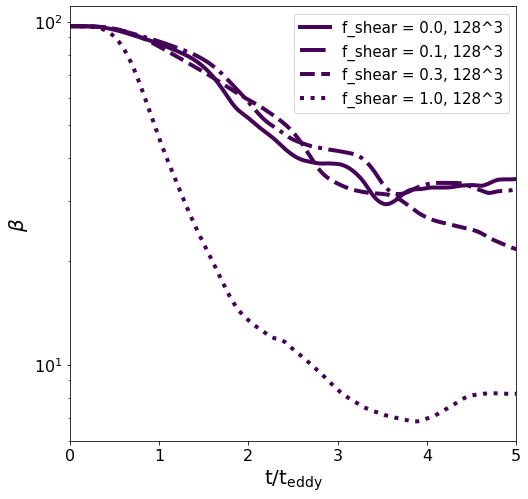

In [9]:

import matplotlib

# dir_name = "Turbulence/"
dir_name = ""

# res = 128
res = 256 

cmap_name = 'viridis'

cmap = matplotlib.cm.get_cmap(cmap_name)
cb_qnt = np.copy(ps.R_lsh)
line_col = cmap(cb_qnt/cb_qnt.max())

def plot_fn(hst):
    # return hst.KE_tot/hst.mass_tot/hst.PB_avg
    # return hst.PB_avg/hst.PB_avg[0]
    # return hst.Pth_avg/hst.PB_avg
    return ps.P_th/hst.PB_avg


for i in [0]:#[1,2,3,4,5]: #range(len(ps.R_lsh)):
    # file_name = f"{dir_name}para_scan{ps.filename_turb_add(i,0)}/Turb.hst"
    
    file_name_1 = f"para_scan_comp_Rlsh{i}_{ps.R_lsh[i]}_res0_128_rseed_1_M_0.5_beta_100/Turb.hst"
    file_name_2 = f"para_scan_comp_fshear_0.1_Rlsh{i}_{ps.R_lsh[i]}_res0_128_rseed_1_M_0.5_beta_100/Turb.hst"
    file_name_3 = f"para_scan_comp_fshear_0.3_Rlsh{i}_{ps.R_lsh[i]}_res0_128_rseed_1_M_0.5_beta_100/Turb.hst"
    # file_name_3 = f"Turbulence/para_scan_Rlsh{i}_{ps.R_lsh[i]}_res0_128_rseed_1_M_0.5_beta_100/Turb.hst"
    file_name_4 = f"para_scan_comp_fshear_1.0_Rlsh{i}_{ps.R_lsh[i]}_res0_128_rseed_1_M_0.5_beta_100/Turb.hst"

    # if i in [0,1,2]:
    #     file_name_3 = f"Turbulence/para_scan_Rlsh{i}_{ps.R_lsh[i]}_res0_256_rseed_1_M_0.5_beta_100/Turb.hst"
    # else:
    #     file_name_3 = f"para_scan_Rlsh{i}_{ps.R_lsh[i]}_res0_256_rseed_1_M_0.5_beta_100/Turb.hst"


    # print(file_name_1)

    try:
        hst1 = hst_data(file_name_1,128**3,True,False)
        hst2 = hst_data(file_name_2,128**3,True,False)
        # print('Hey!')
        hst3 = hst_data(file_name_3,128**3,True,False)
        hst4 = hst_data(file_name_4,128**3,True,False)
    except:
        continue

    # plt.plot(hst.time/ps.t_eddy[i],  linewidth=4, label=f'{ps.R_lsh[i]}') #np.sqrt(2*hst.PB_avg))

    if i!=0:    
        plt.plot(hst1.time/ps.t_eddy[i], plot_fn(hst1), linewidth=4, linestyle='solid', color=line_col[i])
        plt.plot(hst2.time/ps.t_eddy[i], plot_fn(hst2), linewidth=4, linestyle='-.', color=line_col[i])
        plt.plot(hst4.time/ps.t_eddy[i], plot_fn(hst4), linewidth=4, linestyle='dashed', color=line_col[i])
        plt.plot(hst3.time/ps.t_eddy[i], plot_fn(hst3), linewidth=4, linestyle=':', color=line_col[i] )
    else:
        # plt.plot(hst1.time/ps.t_eddy[i], hst1.PB_avg/hst1.PB_avg[0], linewidth=4, label=f'f_shear = 0.0'                    , color=line_col[i]) 
        plt.plot(hst1.time/ps.t_eddy[i], plot_fn(hst1), linewidth=4, label=f'f_shear = 0.0, 128^3', linestyle='solid', color=line_col[i]) #np.sqrt(2*hst.PB_avg))
        plt.plot(hst2.time/ps.t_eddy[i], plot_fn(hst2), linewidth=4, label=f'f_shear = 0.1, 128^3', linestyle='-.', color=line_col[i]) #np.sqrt(2*hst.PB_avg))
        plt.plot(hst3.time/ps.t_eddy[i], plot_fn(hst3), linewidth=4, label=f'f_shear = 0.3, 128^3', linestyle='dashed', color=line_col[i]) 
        plt.plot(hst4.time/ps.t_eddy[i], plot_fn(hst4), linewidth=4, label=f'f_shear = 1.0, 128^3', linestyle=':', color=line_col[i]) #np.sqrt(2*hst.PB_avg))
        # plt.plot(hst3.time/ps.t_eddy[i], plot_fn(hst3), linewidth=4, label=f'f_shear = 0.3, 256^3', linestyle=':', color=line_col[i]) 


    if i in [0,1,2,3,4,5]:
        va = ps.B_mag/np.sqrt(ps.amb_rho)
        l_ch = va * ps.t_eddy[i]
        # print(va)
        # print(ps.t_eddy[i])
        # print(l_ch)
        print(ps.L_box[i]/l_ch)


# plt.axhline(1.0, linestyle='dotted', color='k', linewidth=3)

plt.yscale('log')

plt.xlim(0,5)
# plt.ylim(1,200)

# plt.ylabel(r"E$_{\rm kin}$/E$_{\rm mag}$")
# plt.ylabel(r"P$_B$/P$_{B0}$")
plt.ylabel(r"$\beta$")
plt.xlabel(r't/t$_{\rm eddy}$')

plt.legend()


4.564019853689865
4.5640198536898655
4.5640198536898655
4.564019853689865
4.564019853689865
4.564019853689865


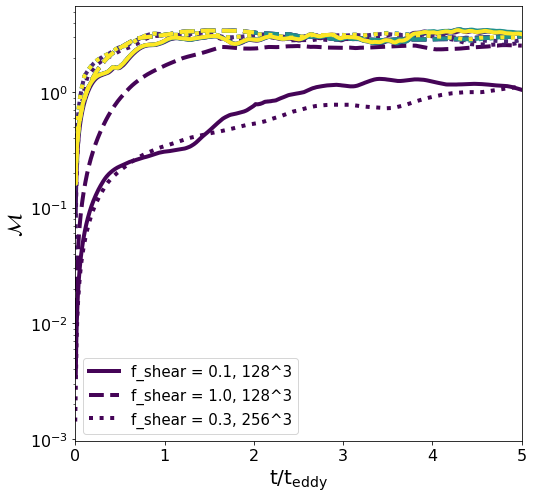

In [41]:
import matplotlib

# dir_name = "Turbulence/"
dir_name = ""

# res = 128
res = 256 

cmap_name = 'viridis'

cmap = matplotlib.cm.get_cmap(cmap_name)
cb_qnt = np.copy(ps.R_lsh)
line_col = cmap(cb_qnt/cb_qnt.max())

for i in [0,1,2,3,4,5]: #range(len(ps.R_lsh)):
    # file_name = f"{dir_name}para_scan{ps.filename_turb_add(i,0)}/Turb.hst"
    
    # file_name_1 = f"para_scan_comp_Rlsh{i}_{ps.R_lsh[i]}_res0_128_rseed_1_M_0.5_beta_100/Turb.hst"
    file_name_2 = f"para_scan_comp_fshear_0.1_Rlsh{i}_{ps.R_lsh[i]}_res0_128_rseed_1_M_0.5_beta_100/Turb.hst"
    # file_name_3 = f"Turbulence/para_scan_Rlsh{i}_{ps.R_lsh[i]}_res0_128_rseed_1_M_0.5_beta_100/Turb.hst"
    file_name_4 = f"para_scan_comp_fshear_1.0_Rlsh{i}_{ps.R_lsh[i]}_res0_128_rseed_1_M_0.5_beta_100/Turb.hst"

    if i in [0,1,2]:
        file_name_3 = f"Turbulence/para_scan_Rlsh{i}_{ps.R_lsh[i]}_res0_256_rseed_1_M_0.5_beta_100/Turb.hst"
    else:
        file_name_3 = f"para_scan_Rlsh{i}_{ps.R_lsh[i]}_res0_256_rseed_1_M_0.5_beta_100/Turb.hst"


    # print(file_name_1)

    try:
        # hst1 = hst_data(file_name_1,res**3,True,False)
        hst2 = hst_data(file_name_2,128**3,True,False)
        # print('Hey!')
        hst3 = hst_data(file_name_3,res**3,True,False)
        hst4 = hst_data(file_name_4,128**3,True,False)
    except:
        continue

    if i!=0:    
        # plt.plot(hst1.time/ps.t_eddy[i], hst1.PB_avg/hst1.PB_avg[0], linewidth=4                    , color=line_col[i]) 
        plt.plot(hst2.time/ps.t_eddy[i], hst2.turb_vel/hst2.cs_avg[0], linewidth=4, linestyle='solid', color=line_col[i]) #np.sqrt(2*hst.PB_avg))
        plt.plot(hst4.time/ps.t_eddy[i], hst4.turb_vel/hst4.cs_avg[0], linewidth=4, linestyle='dashed', color=line_col[i]) #np.sqrt(2*hst.PB_avg))
        plt.plot(hst3.time/ps.t_eddy[i], hst3.turb_vel/hst3.cs_avg[0], linewidth=4, linestyle=':', color=line_col[i] )
    else:
        # plt.plot(hst1.time/ps.t_eddy[i], hst1.PB_avg/hst1.PB_avg[0], linewidth=4, label=f'f_shear = 0.0'                    , color=line_col[i]) 
        plt.plot(hst2.time/ps.t_eddy[i], hst2.turb_vel/hst2.cs_avg[0], linewidth=4, label=f'f_shear = 0.1, 128^3', linestyle='solid', color=line_col[i]) #np.sqrt(2*hst.PB_avg))
        plt.plot(hst4.time/ps.t_eddy[i], hst4.turb_vel/hst4.cs_avg[0], linewidth=4, label=f'f_shear = 1.0, 128^3', linestyle='dashed', color=line_col[i]) #np.sqrt(2*hst.PB_avg))
        plt.plot(hst3.time/ps.t_eddy[i], hst3.turb_vel/hst3.cs_avg[0], linewidth=4, label=f'f_shear = 0.3, 256^3', linestyle=':', color=line_col[i]) 


    if i in [0,1,2,3,4,5]:
        va = ps.B_mag/np.sqrt(ps.amb_rho)
        l_ch = va * ps.t_eddy[i]
        # print(va)
        # print(ps.t_eddy[i])
        # print(l_ch)
        print(ps.L_box[i]/l_ch)


# plt.axhline(1.0, linestyle='dotted', color='k', linewidth=3)

plt.yscale('log')

plt.xlim(0,5)
# plt.ylim(0,0.6)

plt.ylabel(r"$\mathcal{M}$")
plt.xlabel(r't/t$_{\rm eddy}$')

plt.legend()


In [22]:
res = 128

file_name = f"para_scan_Rlsh2_500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.hst"
hst = hst_data(file_name,res**3,True,True)

plt.plot(hst.time/ps.t_eddy[i], hst.cold_gas)

# plt.axhline(ps.M)


ValueError: no field of name cold_gas

In [31]:
fn = "para_scan_Rlsh2_500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.out2.005.athdf"
# fn = "test2/Turb.out2.00010.athdf"

data = ar.athdf(fn)

T = (data['press']/data['rho'])*KELVIN*mu

In [46]:
cold_gas = []
time = []

for N in range(501,566):

    fn = f"para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.out2.00{N}.athdf"

    data = ar.athdf(fn)
    
    plt.figure()
    plt.imshow(np.average(data['rho'],axis=2,weights=data['rho']),vmin=1e0,vmax=1e2)
    # plt.imshow(np.log10(T[:,:,64]))
    
    plt.colorbar()

    plt.savefig(f"para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Plots/Slices/rho_{N}.png")
    plt.close()

    T = (data['press']/data['rho'])*KELVIN*mu

    cold_gas.append(np.sum(data['rho'][T<1.5*ps.T_cold]))
    time.append(N)



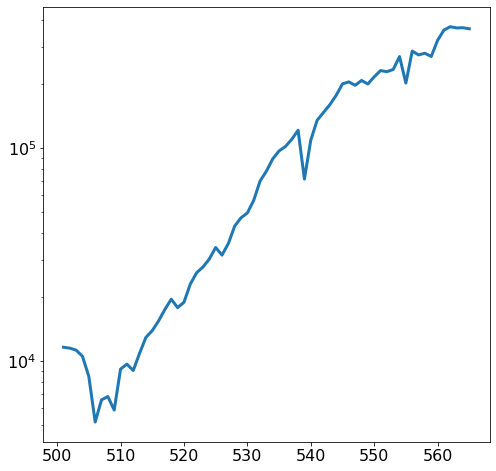

In [47]:

plt.figure()
plt.plot(time,cold_gas)

plt.yscale('log')

In [111]:

# n  = 13 # 400 
n_list  = range(501) # [0,3,5,7,10,13] # 400 

# fn = f"para_scan_Rlsh6_10_res0_128_rseed_1_M_0.25_chi_100_beta_100/Turb.out2.00{n}.athdf"
# fn = f"para_scan_Rlsh5_50_res0_128_rseed_1_M_0.25_chi_100_hydro/Turb.out2.00{n}.athdf"
# fn = f"Turbulence/para_scan_Rlsh6_10_res0_128_rseed_1_M_0.25_beta_100/Turb.out2.00{n}.athdf"
# fn = f"para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.out2.00{n}.athdf"

R_i = 1

for n in n_list:

    print(f'n: {n}')

    fn_0 = f"para_scan_comp_Rlsh{R_i}_{ps.R_lsh[R_i]}_res0_128_rseed_1_M_0.5_beta_0.1/Turb.out2.{str(n).zfill(5)}.athdf"

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(12,10))
    
    # print(np.shape(data['x3v']), np.min(data['x3v']), np.max(data['x3v']))
    # print(np.shape(data['Bcc1']))
 
    data = ar.athdf(fn_0)

    plot_data =  np.roll(np.roll(data['rho'], 64, axis=0), -32, axis=0) # data['rho']
    wt_data   =  np.roll(np.roll(data['rho'], 64, axis=0), -32, axis=0) # data['rho']
 
    # den_plot = ax.imshow(plot_data[64,:,:],vmin=0,vmax=3)
    den_plot = ax.imshow(plot_data[:,64,:],vmin=0,vmax=3)
 
    ax.set_title(f"Rlsh: {ps.R_lsh[R_i]}, N: {n}")
    
    print("\n")
    
    fig.colorbar(den_plot, ax=ax)


    plt.savefig(f"Plots/sub_alfvenic_rho_evolution/Rlsh_50/rho_{str(n).zfill(5)}.png")

    plt.close()

# plt.imshow(np.average(plot_data,axis=2,weights=wt_data)) # ,vmin=1,vmax=1e2)
# plt.streamplot(data['x1v'], data['x3v'], data['Bcc1'][:,int(res/2),:], data['Bcc3'][:,int(res/2),:])# , density=30)
# T = (data['press']/data['rho'])*KELVIN*mu


n: 0


n: 1


n: 2


n: 3


n: 4


n: 5


n: 6


n: 7


n: 8


n: 9


n: 10


n: 11


n: 12


n: 13


n: 14


n: 15


n: 16


n: 17


n: 18


n: 19


n: 20


n: 21


n: 22


n: 23


n: 24


n: 25


n: 26


n: 27


n: 28


n: 29


n: 30


n: 31


n: 32


n: 33


n: 34


n: 35


n: 36


n: 37


n: 38


n: 39


n: 40


n: 41


n: 42


n: 43


n: 44


n: 45


n: 46


n: 47


n: 48


n: 49


n: 50


n: 51


n: 52


n: 53


n: 54


n: 55


n: 56


n: 57


n: 58


n: 59


n: 60


n: 61


n: 62


n: 63


n: 64


n: 65


n: 66


n: 67


n: 68


n: 69


n: 70


n: 71


n: 72


n: 73


n: 74


n: 75


n: 76


n: 77


n: 78


n: 79


n: 80


n: 81


n: 82


n: 83


n: 84


n: 85


n: 86


n: 87


n: 88


n: 89


n: 90


n: 91


n: 92


n: 93


n: 94


n: 95


n: 96


n: 97


n: 98


n: 99


n: 100


n: 101


n: 102


n: 103


n: 104


n: 105


n: 106


n: 107


n: 108


n: 109


n: 110


n: 111


n: 112


n: 113


n: 114


n: 115


n: 116


n: 117


n: 118


n: 119


n: 120


n: 121


n: 122


n: 

n: 0
0	1	2	3	4	5	

n: 1
0	1	2	3	4	5	

n: 2
0	1	2	3	4	5	

n: 3
0	1	2	3	4	5	

n: 4
0	1	2	3	4	5	

n: 5
0	1	2	3	4	5	

n: 6
0	1	2	3	4	5	

n: 7
0	1	2	3	4	5	

n: 8
0	1	2	3	4	5	

n: 9
0	1	2	3	4	5	

n: 10


/tmp/ipykernel_14608/3377471434.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


0	1	2	3	4	5	

n: 11
0	1	2	3	4	5	

n: 12
0	1	2	3	4	5	

n: 13
0	1	2	3	4	5	



<Figure size 576x576 with 0 Axes>

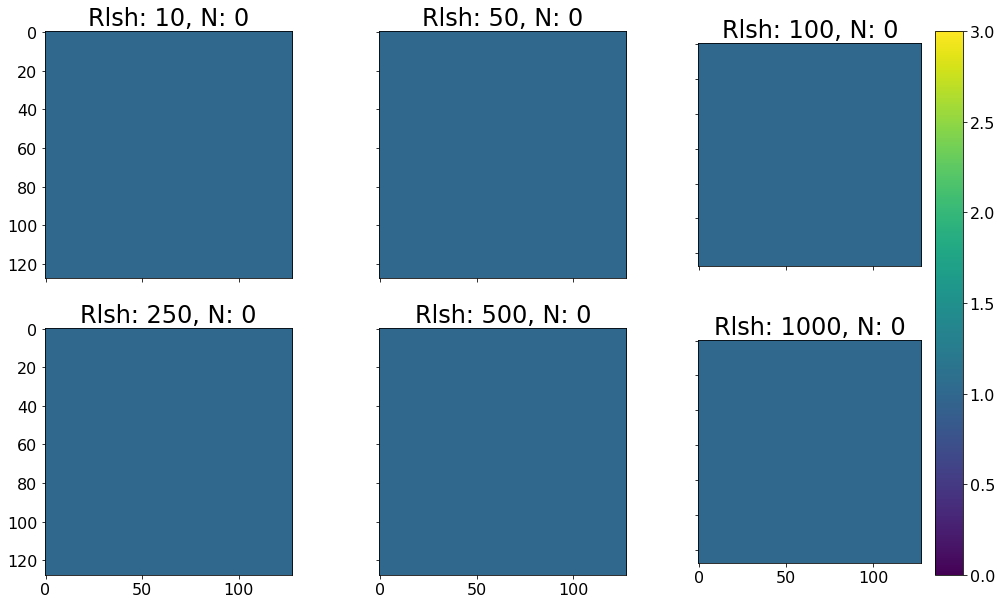

<Figure size 576x576 with 0 Axes>

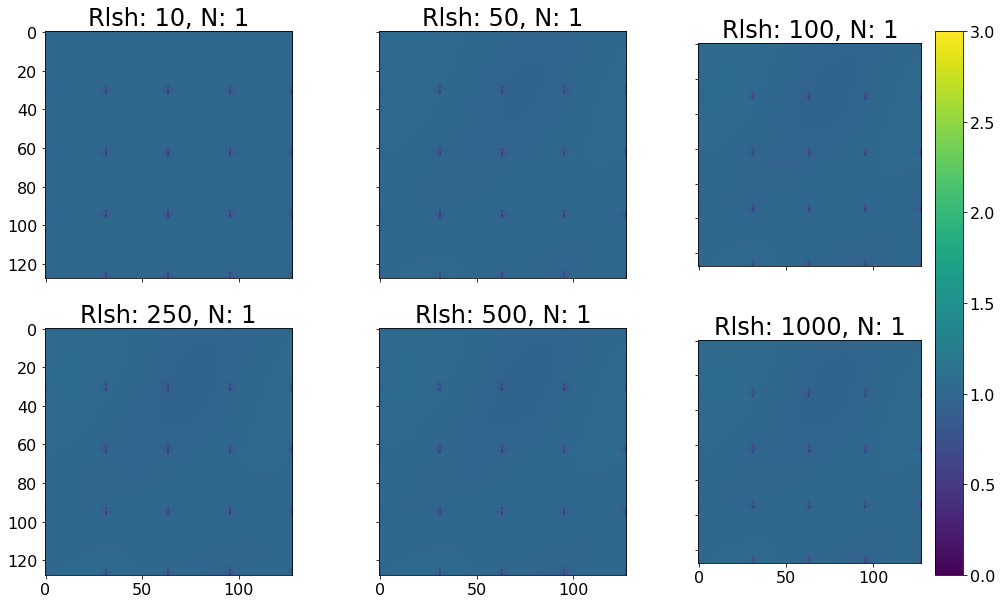

<Figure size 576x576 with 0 Axes>

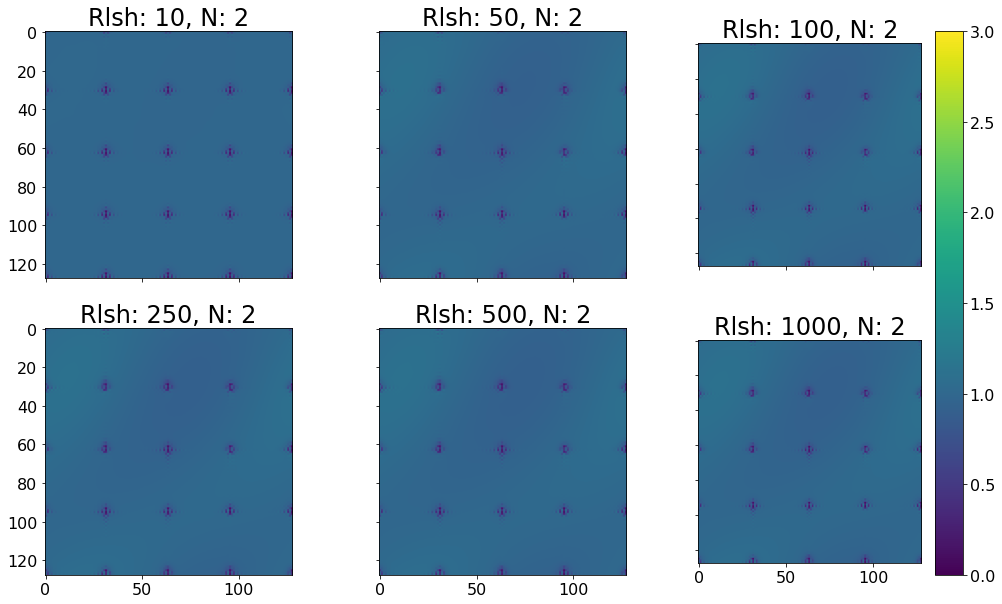

<Figure size 576x576 with 0 Axes>

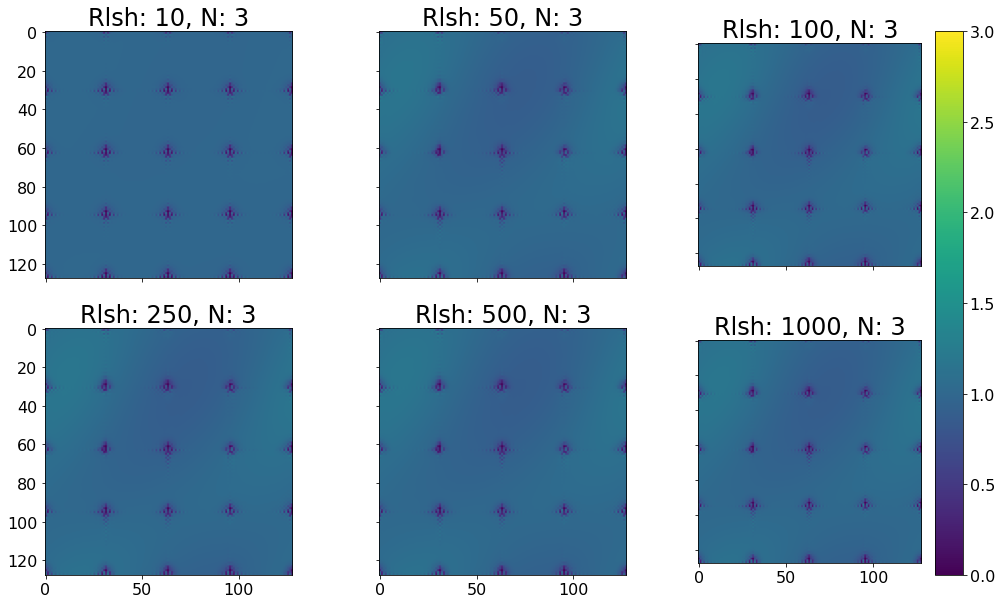

<Figure size 576x576 with 0 Axes>

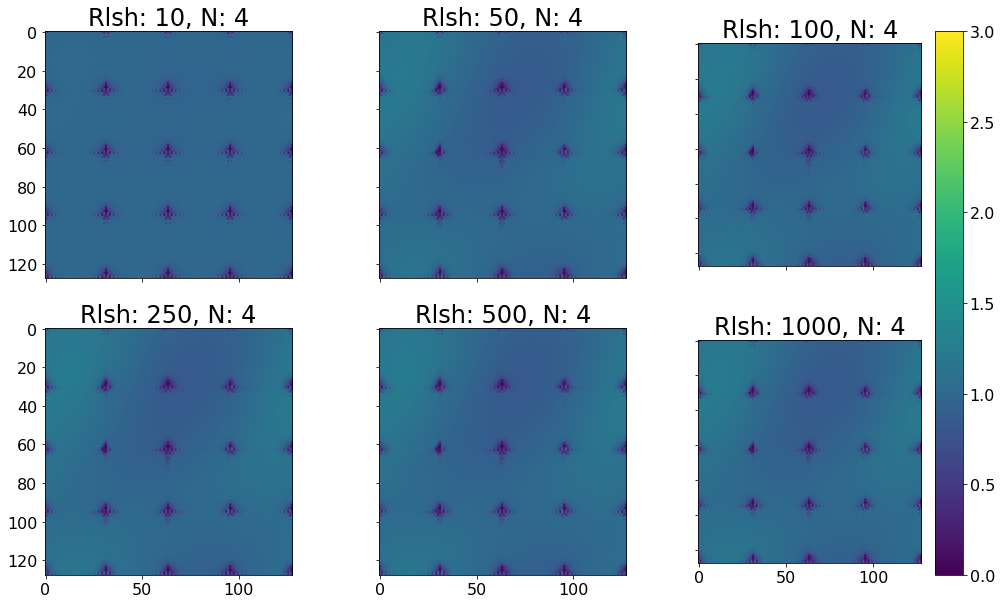

<Figure size 576x576 with 0 Axes>

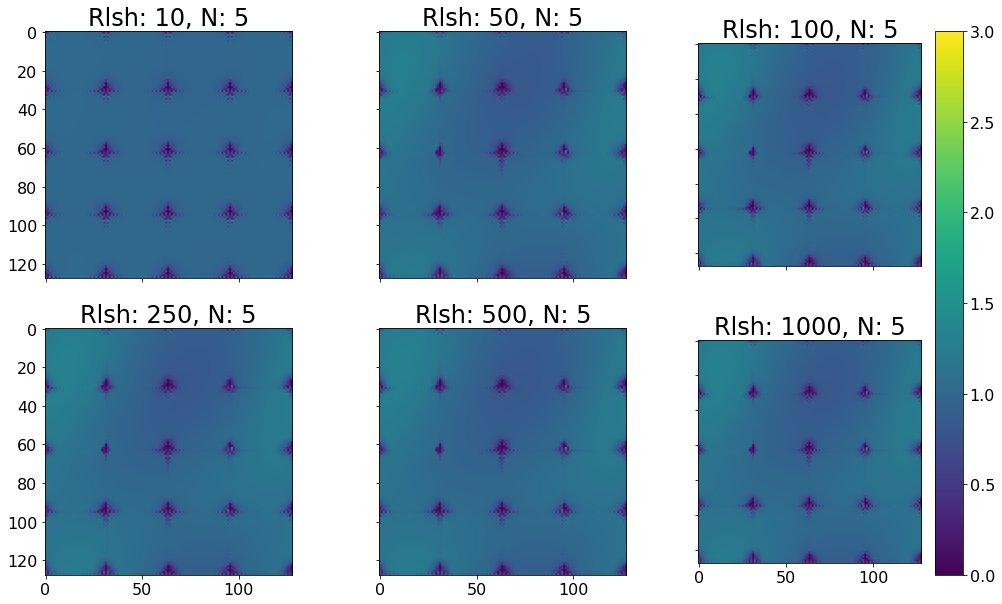

<Figure size 576x576 with 0 Axes>

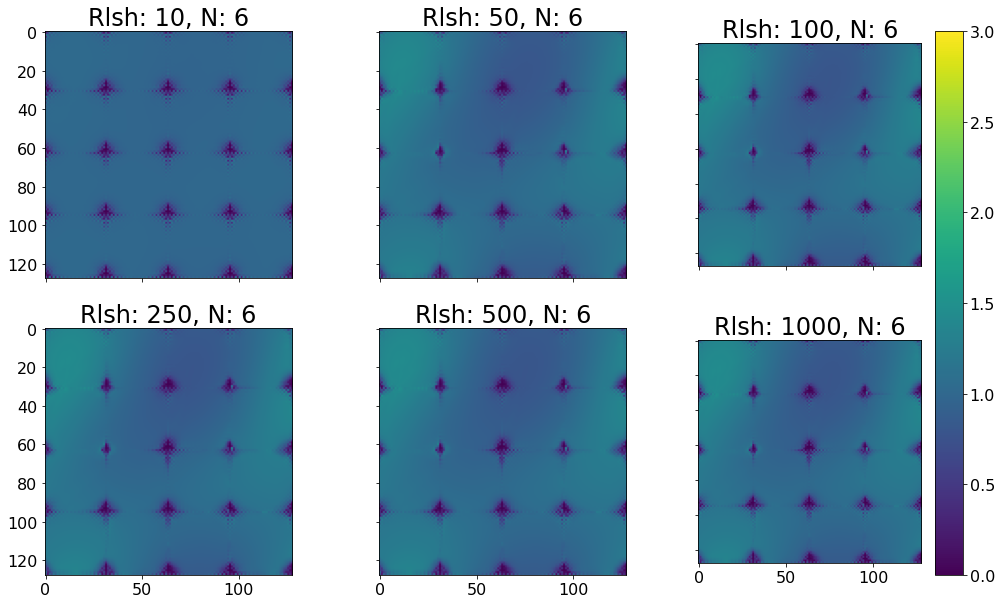

<Figure size 576x576 with 0 Axes>

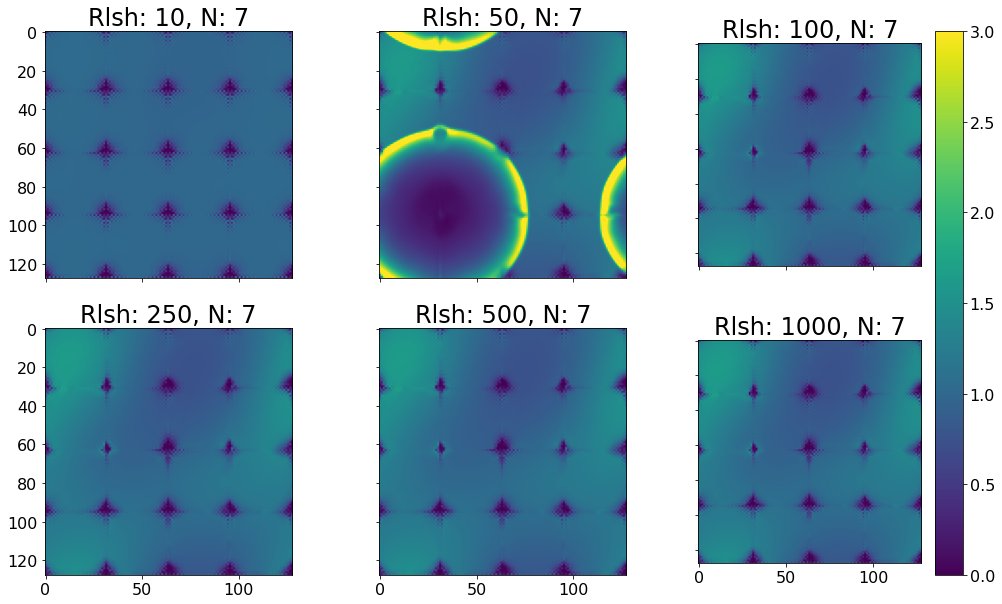

<Figure size 576x576 with 0 Axes>

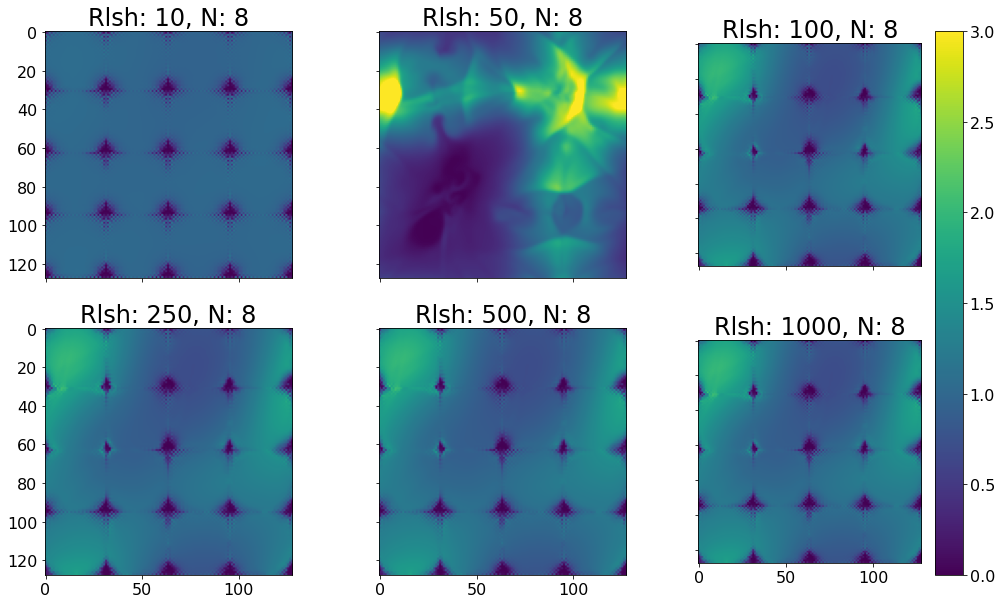

<Figure size 576x576 with 0 Axes>

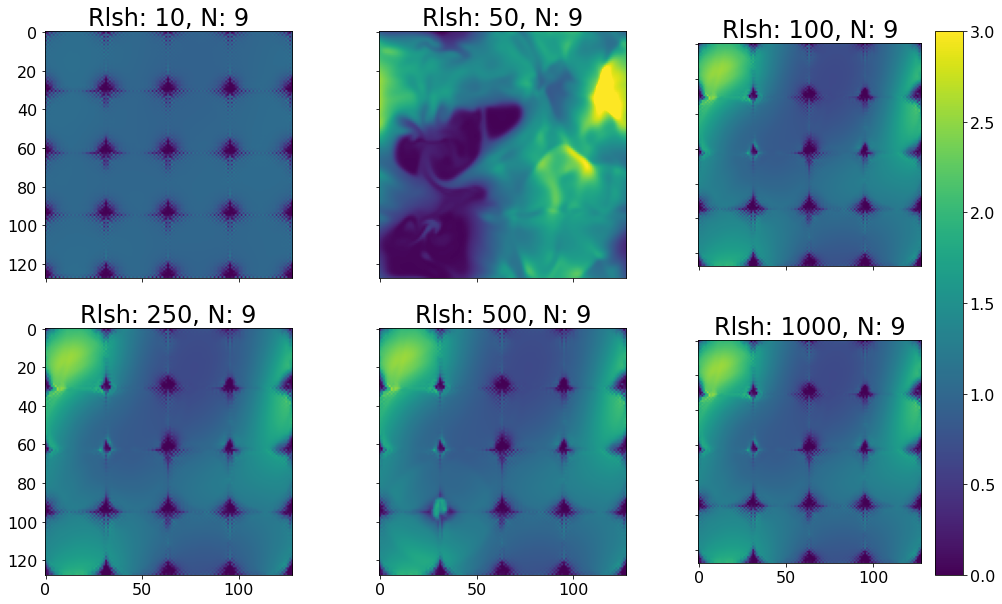

<Figure size 576x576 with 0 Axes>

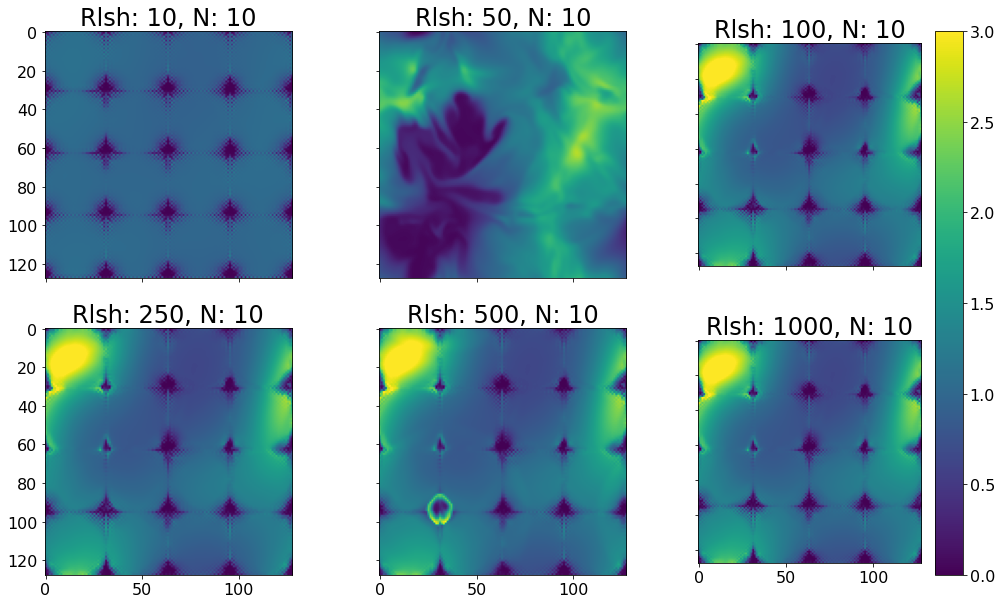

<Figure size 576x576 with 0 Axes>

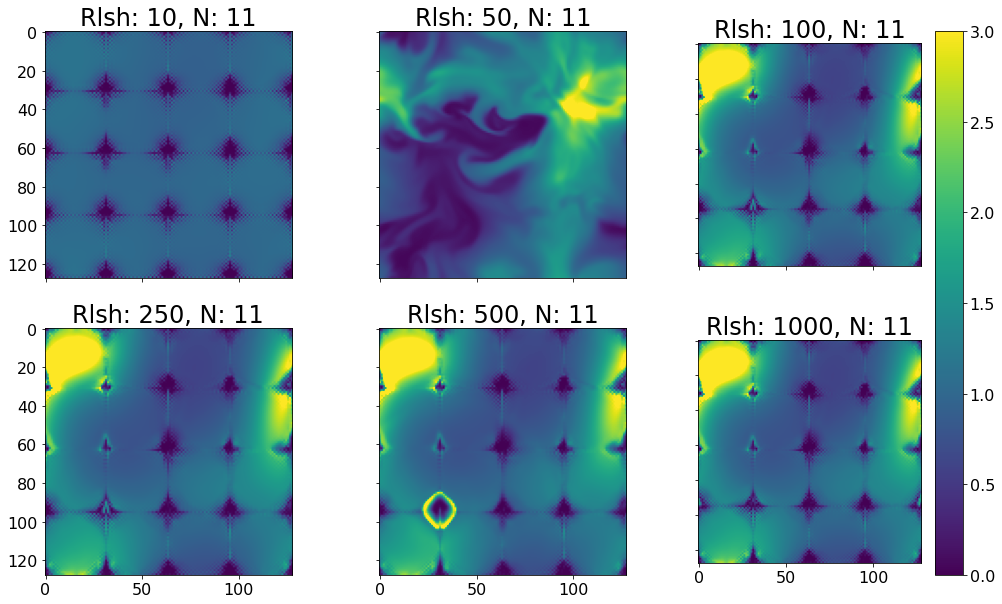

<Figure size 576x576 with 0 Axes>

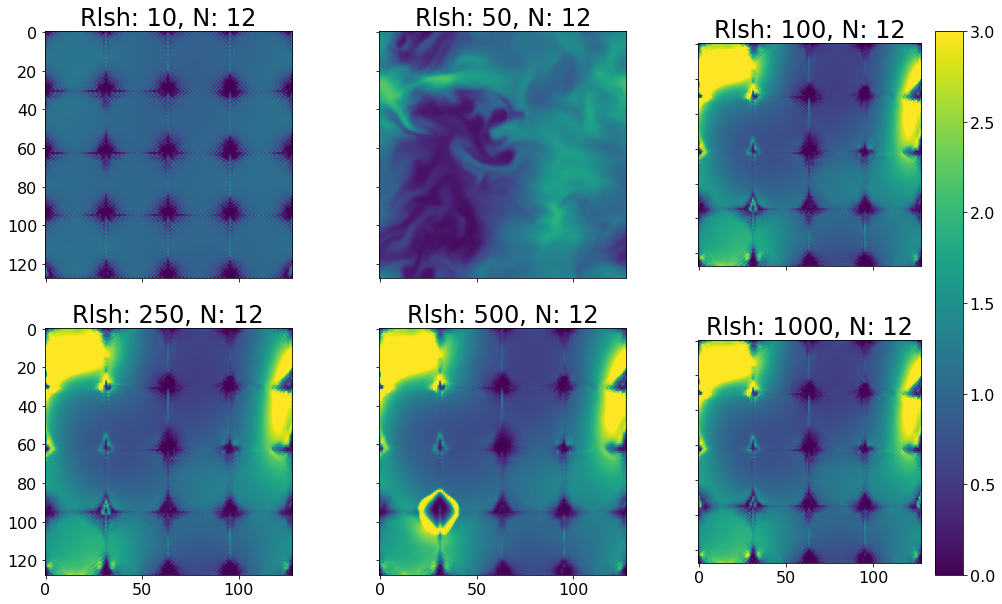

<Figure size 576x576 with 0 Axes>

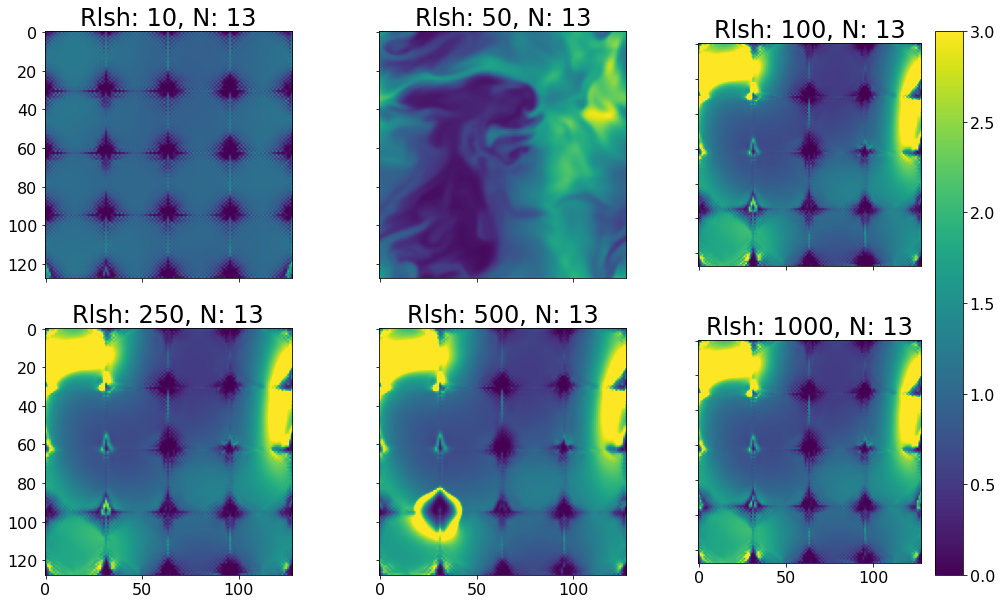

In [101]:
# n  = 13 # 400 
n_list  = range(14) # [0,3,5,7,10,13] # 400 

# fn = f"para_scan_Rlsh6_10_res0_128_rseed_1_M_0.25_chi_100_beta_100/Turb.out2.00{n}.athdf"
# fn = f"para_scan_Rlsh5_50_res0_128_rseed_1_M_0.25_chi_100_hydro/Turb.out2.00{n}.athdf"
# fn = f"Turbulence/para_scan_Rlsh6_10_res0_128_rseed_1_M_0.25_beta_100/Turb.out2.00{n}.athdf"
# fn = f"para_scan_Rlsh4_2500_res0_128_rseed_1_M_0.5_chi_100_beta_100/Turb.out2.00{n}.athdf"

for n in n_list:

    print(f'n: {n}')

    fn_0 = f"para_scan_comp_Rlsh0_10_res0_128_rseed_1_M_0.5_beta_0.1/Turb.out2.{str(n).zfill(5)}.athdf"
    fn_1 = f"para_scan_comp_Rlsh1_50_res0_128_rseed_1_M_0.5_beta_0.1/Turb.out2.{str(n).zfill(5)}.athdf"
    fn_2 = f"para_scan_comp_Rlsh2_100_res0_128_rseed_1_M_0.5_beta_0.1/Turb.out2.{str(n).zfill(5)}.athdf"
    fn_3 = f"para_scan_comp_Rlsh3_250_res0_128_rseed_1_M_0.5_beta_0.1/Turb.out2.{str(n).zfill(5)}.athdf"
    fn_4 = f"para_scan_comp_Rlsh4_500_res0_128_rseed_1_M_0.5_beta_0.1/Turb.out2.{str(n).zfill(5)}.athdf"
    fn_5 = f"para_scan_comp_Rlsh5_1000_res0_128_rseed_1_M_0.5_beta_0.1/Turb.out2.{str(n).zfill(5)}.athdf"
    
    fn = [fn_0, fn_1, fn_2, fn_3, fn_4, fn_5]
    
    
    plt.figure()
    fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(17,10))
    
    # print(np.shape(data['x1v']), np.min(data['x1v']), np.max(data['x1v']))
    # print(np.shape(data['x3v']), np.min(data['x3v']), np.max(data['x3v']))
    # print(np.shape(data['Bcc1']))
    
    
    for i in range(len(fn)):

        print(f"{i}\t", end='')
    
        data = ar.athdf(fn[i])
        plot_data =  np.roll(np.roll(data['rho'], 64, axis=0), -32, axis=0) # data['rho']
        wt_data   =  np.roll(np.roll(data['rho'], 64, axis=0), -32, axis=0) # data['rho']
    
        den_plot = ax[int(i/3), i%3 ].imshow(plot_data[64,:,:],vmin=0,vmax=3)
    
        ax[int(i/3), i%3 ].set_title(f"Rlsh: {ps.R_lsh[i]}, N: {n}")
    
    print("\n")
    
    fig.colorbar(den_plot, ax=ax[:, 2])


    plt.savefig(f"Plots/sub_alfvenic_rho_evolution/rho_{str(n).zfill(5)}.png")

# plt.imshow(np.average(plot_data,axis=2,weights=wt_data)) # ,vmin=1,vmax=1e2)
# plt.streamplot(data['x1v'], data['x3v'], data['Bcc1'][:,int(res/2),:], data['Bcc3'][:,int(res/2),:])# , density=30)
# T = (data['press']/data['rho'])*KELVIN*mu


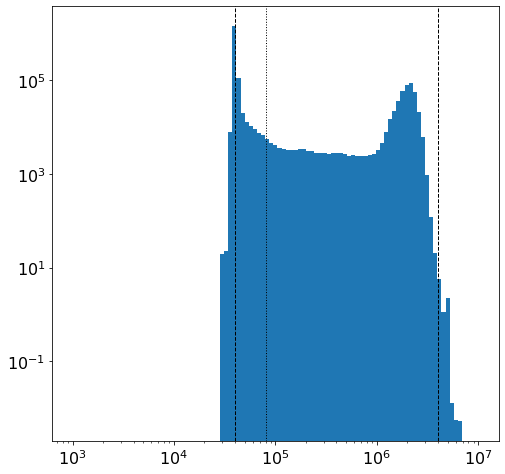

In [60]:
# bins_arr = np.logspace(-2,2,num=100)
bins_arr = np.logspace(3,7,num=100)

# plt.hist(np.ravel(data['rho']),bins=bins_arr)
plt.hist(np.ravel(T),bins=bins_arr,weights=np.ravel(data['rho']))

plt.xscale('log')
plt.yscale('log')

plt.axvline(4e4, color='k', linestyle='dashed', linewidth=1)
plt.axvline(4e6, color='k', linestyle='dashed', linewidth=1)
plt.axvline(ps.T_cold, color='k', linestyle='dotted', linewidth=1)

# plt.axvline(1)
# plt.axvline(100)


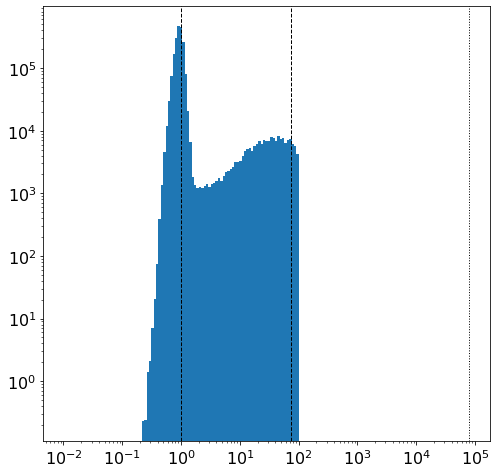

In [57]:
bins_arr = np.logspace(-2,2,num=100)

plt.hist(np.ravel(data['rho']),bins=bins_arr,weights=np.ravel(data['rho']))

plt.xscale('log')
plt.yscale('log')

plt.axvline(1e0, color='k', linestyle='dashed', linewidth=1)
plt.axvline(75, color='k', linestyle='dashed', linewidth=1)
plt.axvline(ps.T_cold, color='k', linestyle='dotted', linewidth=1)

# plt.axvline(1)
# plt.axvline(100)


In [23]:
print(np.max(data['press']))

0.10814202226673592
